# NBA Stats Analysis
This is a NBA players exploratory analysis to experiment different visualizations and find various insights about basketball statistics leaders.

Firstly, we need to get the data from [basketball reference](https://www.basketball-reference.com/). We used a script to get the data. The script is based on [data.world](https://data.world/etocco/nba-player-stats). We define the range of seasons we want and create the different urls.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

years = range(1955,2023) #the range of seasons we want 
urls = {} #dictionary containing the different urls
for year in years:
    urls["url" + str(year)] = f"https://www.basketball-reference.com/leagues/NBA_{year+1}_per_game.html"

Next we read the html pages and save them in a dictionary. We also create a new attribute for every season that contains the season (e.g. 1997-1998)

In [2]:
season_from = years.start # for season column
dictionary_data = {}
for page in urls:
    dictionary_data["pl" + str(season_from + 1)] = pd.read_html(urls[page])[0]
    time.sleep(5) #pausing the script for 5 seconds to avoid getting error message "too many requests" from server
    dictionary_data["pl" + str(season_from + 1)]['Season'] = str(season_from)+'-'+str(season_from + 1)[-2:]
    season_from += 1

Next we save the data in a dataframe, drop duplicates and rows with no information:

In [3]:
data = pd.concat(dictionary_data)
data = data.drop_duplicates()
data.drop(data[data['Rk'] == 'Rk'].index, inplace = True) # removes rows with no valuable information
data.reset_index(drop=True, inplace=True)

Because some players have special characters in their names, we remove those:

In [4]:
data['Player'] = data['Player'].str.strip('*')

Next we read the mvp data table

In [5]:
mvp_table = pd.read_html('https://www.basketball-reference.com/awards/mvp.html')[0].droplevel(0, axis = 1)
mvp_table['MVP'] = True

Now we merge the mvp data with the rest.

In [6]:
data = data.merge(mvp_table[['Season','Player','MVP']], on=['Season','Player'], how='left')
data.MVP.fillna(False, inplace=True) #filling Nan MVP values with False

Transforming the numeric data column from object type to integer or float:

In [7]:
column_names_numeric = ['Age','G','GS','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%',
            'FT','FTA','FT%','ORB','DRB','TRB','AST','BLK','STL','TOV','PF','PTS']
data[column_names_numeric] = data[column_names_numeric].apply(pd.to_numeric, errors='ignore')

Each row contains stats of one player for one particular regular season. However, one player could have three or more rows of data for one particular season if he was traded mid-season and played for more than one team (one row for his time with the first team, one row for his time with the team he got transfered to and one row for the averages of both together).

We print a sample of the data to see the different columns and information contained in each row of this dataset

In [8]:
pd.set_option('max_columns', None) #setting to print all the columns
data.sample(5, random_state=0)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,MVP
6890,316,Mike Woodson,SG,26,KCK,78,3.0,25.6,6.8,13.7,0.496,0.1,0.3,0.238,6.7,13.4,0.501,0.499,3.4,4.2,0.800,0.9,1.7,2.5,1.8,1.5,0.4,1.8,2.8,17.0,1984-85,False
2379,65,Lamar Green,PF,24,PHO,67,NaN,14.8,2.0,4.4,0.446,NaN,NaN,NaN,2.0,4.4,0.446,0.446,1.0,1.3,0.733,NaN,NaN,5.2,0.7,NaN,NaN,NaN,2.0,5.0,1971-72,False
4340,268,Scott Wedman,SF,25,KCK,81,NaN,36.6,7.5,14.7,0.509,NaN,NaN,NaN,7.5,14.7,0.509,0.509,2.7,3.1,0.870,1.8,3.9,5.7,2.5,1.2,0.3,2.0,3.0,17.7,1977-78,False
7810,122,Craig Hodges,SG,27,PHO,23,0.0,20.1,3.8,7.7,0.489,1.3,2.5,0.544,2.4,5.3,0.463,0.576,1.2,1.4,0.844,0.3,1.1,1.4,1.9,0.7,0.1,1.2,1.7,10.1,1987-88,False
15756,249,Stephon Marbury,PG,26,TOT,81,81.0,40.2,7.4,17.1,0.431,1.1,3.4,0.318,6.3,13.7,0.460,0.463,4.4,5.4,0.817,0.7,2.5,3.2,8.9,1.6,0.1,3.1,2.1,20.2,2003-04,False


After checking the column `Rk` which actually means Rating, we find out that it does not give much information. Basically, it is an id of the particular player for a particular season, which sorts the players of one season based on their surname. For example, the player `Paul Arizin` is rank 1 for the 1960-61 because his surname is alphabetically first for the season 55-56

In [9]:
data.loc[data.Rk=='1'].head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,MVP
0,1,Paul Arizin,SF,27,PHW,72,NaN,37.8,8.6,19.1,0.448,NaN,NaN,NaN,8.6,19.1,0.448,0.448,7.0,8.7,0.810,NaN,NaN,7.5,2.6,NaN,NaN,NaN,3.9,24.2,1955-56,False
106,1,Forest Able,G,24,SYR,1,NaN,1.0,0.0,2.0,0.000,NaN,NaN,NaN,0.0,2.0,0.000,0.000,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,0.0,1956-57,False
221,1,Paul Arizin,SF,29,PHW,68,NaN,35.0,7.1,18.1,0.393,NaN,NaN,NaN,7.1,18.1,0.393,0.393,6.5,8.0,0.809,NaN,NaN,7.4,2.0,NaN,NaN,NaN,3.5,20.7,1957-58,False
332,1,Paul Arizin,SF,30,PHW,70,NaN,40.0,9.0,20.9,0.431,NaN,NaN,NaN,9.0,20.9,0.431,0.431,8.4,10.3,0.813,NaN,NaN,9.1,1.7,NaN,NaN,NaN,3.8,26.4,1958-59,False
442,1,Gary Alcorn,C,23,DET,58,NaN,11.6,1.6,5.4,0.292,NaN,NaN,NaN,1.6,5.4,0.292,0.292,0.8,1.4,0.571,NaN,NaN,4.8,0.4,NaN,NaN,NaN,2.1,4.0,1959-60,False


As a result, we drop the column `Rk`:

In [10]:
data = data.drop(columns=['Rk'])

We will remove all the players that averaged less than 1 minute played

In [11]:
data = data.loc[(data.MP >= 1)].copy()

Here we can see the description of the abbreviation columns, as seen in [basketball-reference.com](https://www.basketball-reference.com/leagues/NBA_2022_per_game.html):
* Pos -- Position
* Age -- Player's age on February 1 of the season
* Tm -- Team
* G -- Games
* GS -- Games Started
* MP -- Minutes Played Per Game
* FG -- Field Goals Per Game
* FGA -- Field Goal Attempts Per Game
* FG% -- Field Goal Percentage
* 3P -- 3-Point Field Goals Per Game
* 3PA -- 3-Point Field Goal Attempts Per Game
* 3P% -- 3-Point Field Goal Percentage
* 2P -- 2-Point Field Goals Per Game
* 2PA -- 2-Point Field Goal Attempts Per Game
* 2P% -- 2-Point Field Goal Percentage
* eFG% -- Effective Field Goal Percentage. This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
* FT -- Free Throws Per Game
* FTA -- Free Throw Attempts Per Game
* FT% -- Free Throw Percentage
* ORB -- Offensive Rebounds Per Game
* DRB -- Defensive Rebounds Per Game
* TRB -- Total Rebounds Per Game
* AST -- Assists Per Game
* STL -- Steals Per Game
* BLK -- Blocks Per Game
* TOV -- Turnovers Per Game
* PF -- Personal Fouls Per Game
* PTS -- Points Per Game

Now we will check the shape of the dataframe, (number of rows, number of columns):

In [12]:
data.shape

(27845, 31)

Next we will use the command `describe()` to check basics statistics of every column

In [13]:
data.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,27845.000000,27845.000000,22703.000000,27845.000000,27845.000000,27845.000000,27720.000000,23139.000000,23139.000000,19356.000000,27845.000000,27845.000000,27644.000000,27720.000000,27845.000000,27845.000000,26709.000000,25009.000000,25009.000000,27845.000000,27845.000000,25009.000000,25009.000000,23857.000000,27845.000000,27845.000000
mean,26.589226,49.382690,22.908602,20.091363,3.183049,7.074911,0.436269,0.472605,1.373599,0.262128,2.790016,5.933072,0.458501,0.463470,1.594498,2.141110,0.724244,1.013111,2.503407,3.676829,1.888267,0.661054,0.402743,1.233831,1.959332,8.351388
std,3.920795,26.649657,28.211070,10.217577,2.314851,4.820666,0.098429,0.655540,1.736633,0.171476,2.198918,4.468703,0.105958,0.102925,1.450428,1.844109,0.143898,0.861486,1.825383,2.785346,1.813667,0.477257,0.494941,0.830903,0.898774,6.129126
min,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,25.000000,0.000000,11.600000,1.400000,3.300000,0.399000,0.000000,0.000000,0.154000,1.100000,2.500000,0.419000,0.426000,0.600000,0.800000,0.663000,0.400000,1.200000,1.700000,0.600000,0.300000,0.100000,0.600000,1.300000,3.600000
50%,26.000000,55.000000,7.000000,19.300000,2.600000,5.900000,0.441000,0.100000,0.600000,0.308000,2.200000,4.700000,0.465000,0.473000,1.200000,1.600000,0.750000,0.800000,2.100000,3.000000,1.300000,0.600000,0.200000,1.000000,1.900000,6.800000
75%,29.000000,75.000000,43.000000,28.500000,4.500000,9.900000,0.484000,0.800000,2.300000,0.368000,4.000000,8.300000,0.506000,0.513000,2.200000,2.900000,0.814000,1.400000,3.300000,4.900000,2.600000,0.900000,0.500000,1.700000,2.600000,11.800000
max,44.000000,88.000000,83.000000,48.500000,20.000000,39.500000,1.000000,5.300000,13.200000,1.000000,20.000000,39.500000,1.000000,1.500000,10.600000,17.000000,1.000000,7.200000,13.700000,27.200000,14.500000,3.700000,6.000000,5.700000,6.000000,50.400000


Even with this basic statistics we can find some interesting conclusions:
* The youngest player that played at least 1 game in any season was 18 years old and the olderst 44 years old
* The most games played per season from one player were 88 games
* The most average minutes played per game for one season was 48.5
* The most aveage field goal attempts per game for one season were 39.5
* The most average 3 point attempts per game for one season were 13.2
* The highest effective field goal percentage was 150%
* The highest avergae free throw attempts per game were for one season were 17
* The highest average rebounds per game for one season were 27.2

Hiding warnings for different plots afterwards

In [14]:
import warnings
warnings.filterwarnings(action='ignore')

## Age 
Now we will see the youngest players that played at least one game in one season:

In [15]:
data.loc[data.Age == data.Age.min()][['Player','Season','Age']].reset_index(drop=True)

,Player,Season,Age
0,Bill Willoughby,1975-76,18
1,Kobe Bryant,1996-97,18
2,Jermaine O'Neal,1996-97,18
3,Tracy McGrady,1997-98,18
4,Al Harrington,1998-99,18
5,Bruno Šundov,1998-99,18
6,Maciej Lampe,2003-04,18
7,Darko Miličić,2003-04,18
8,Andris Biedriņš,2004-05,18
9,Andrew Bynum,2005-06,18


Now we will check the oldest players:

In [16]:
data.loc[data.Age == data.Age.max()][['Player','Season','Age']].reset_index(drop=True)

,Player,Season,Age
0,Kevin Willis,2006-07,44


Last we will check the average age of an nba player for those seasons. The problem is that some players played for different teams the same season. That is why we will only keep one row per player per season. Also, we will keep the minimum age of a player that played for more than one team in one particular season (meaning his age when the season started):

In [17]:
age_data = data[['Player','Age','Season']].groupby(['Season','Player']).min().reset_index().copy()

Now we can see the average age:

In [18]:
age_data.Age.mean()

26.503977847127597

We will also check the weighted average age taking into consideration the different seasons. This average age is the average of average ages of nba players per season

In [19]:
age_data.groupby(['Season']).mean().reset_index().Age.mean()

26.405556089420557

Now we will also analyze the evolution of the average age of an nba player over the years

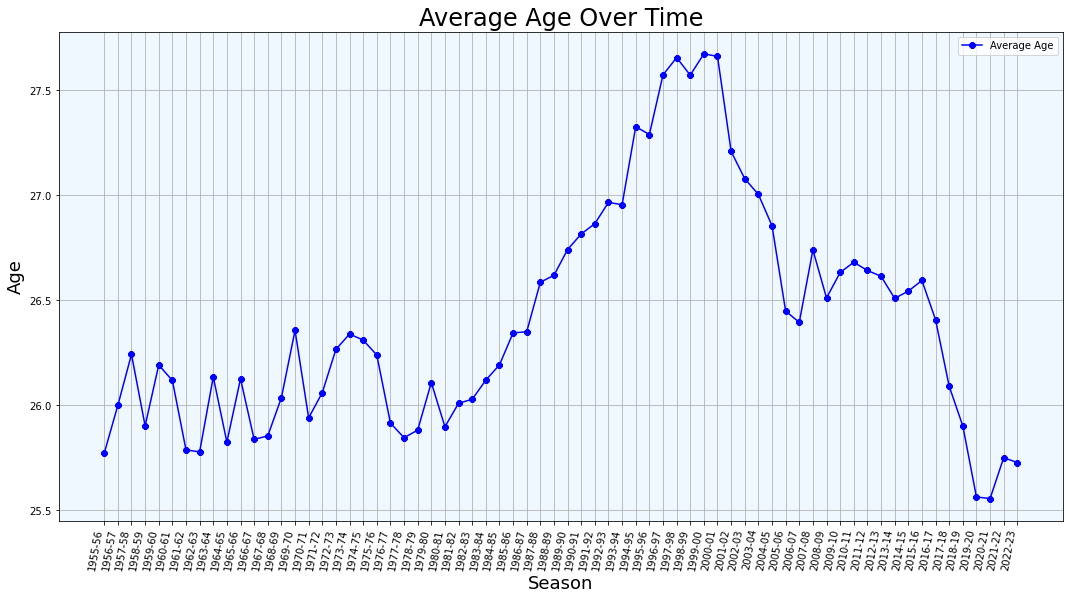

In [20]:
fig, ax = plt.subplots(figsize=(18,9))
grouped_age_per_season = age_data.groupby(['Season']).mean().reset_index()
grouped_age_per_season.plot(ax=ax, marker="8", label="Average Age over time", color='blue')
plt.title('Average Age Over Time', fontdict ={'size': 24}, loc='center')
plt.ylabel('Age', fontdict ={'size': 18})
plt.xlabel('Season',fontdict ={'size': 18})
ax.grid(which='both') #add grid
plt.xticks(rotation=80, ha='right') #rotate xticks
ax.set_facecolor("aliceblue") #setting background color
ax.set_xticklabels(grouped_age_per_season.Season) #setting xticks labels
ax.set_xticks(np.arange((grouped_age_per_season.shape[0]))) #setting range of xticks 
plt.legend(loc="upper right", labels=['Average Age'])
plt.show()

#### Conclusion
During the 1990s the game had the highest average age, probably due to traditional big men and post-game focus. After that period the average keeps reducing until the 21-22 season where it hit the all time low. There is a clear tendency that the average age is dropping every season after the 2000s. The NBA is becoming a young man's league, since players consistently join the league as 19-year-olds after just spending one year in college or overseas. Also, the fact that the game is becoming quicker, more possessions, more transition 3 point shots etc. makes it tougher for older players to stick around for long.

Next, we will calculate for every season the percentage of players that are aged under 24 years old. For that we calculate the frequencies of players aged under 23 for every season and the frequencies of any-aged player for every season. Then we devide the firstly mentioned with the second mentioned to calculate the percentage:

In [21]:
freq_young_perseason = age_data[['Season','Age']].loc[age_data.Age < 24].groupby(['Season']).count().reset_index()
#finding the frequencies of players under 23 years old
freq_young_perseason = freq_young_perseason.rename(columns= {'Age':'Freq_under_24'}) #renaming
freq_players_perseason = age_data[['Season','Age']].groupby(['Season']).count().reset_index()
freq_players_perseason = freq_players_perseason.rename(columns= {'Age':'Freq'}) #renaming
freq_season_age = freq_players_perseason.merge(freq_young_perseason,on= 'Season') #merging dfs
freq_season_age['percentage_under_24'] = freq_season_age['Freq_under_24'] / freq_season_age['Freq']

Now we can visualize the results. It is clear that there are more young under 24 years old NBA players as the seasons have progressed. In fact, since the 95-96 season the percentage of under 24 year old players in the NBA has more than doubled comparing it to today:

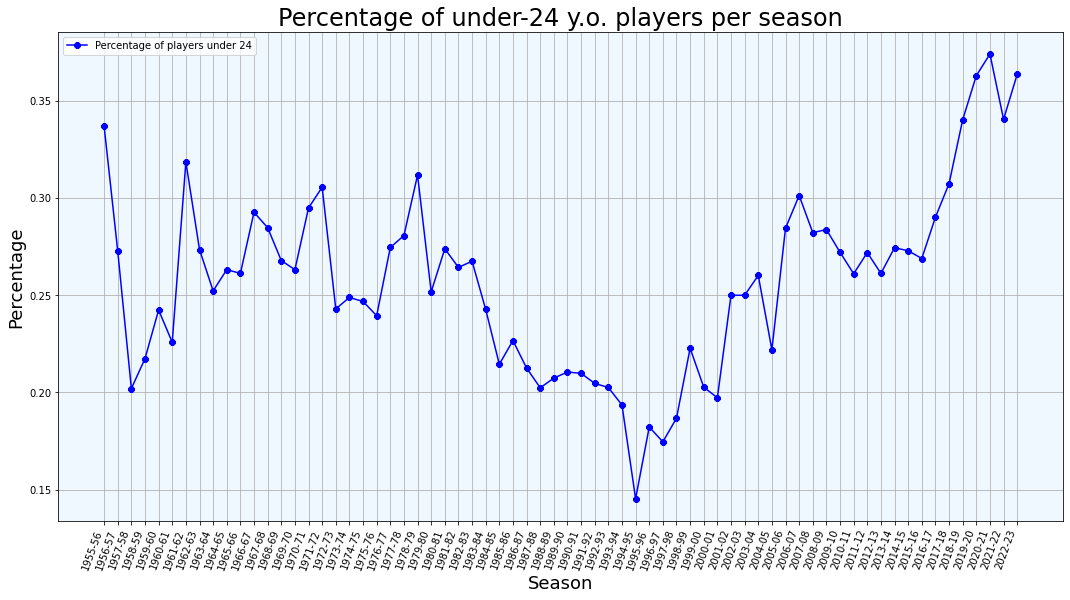

In [22]:
fig, ax = plt.subplots(figsize=(18,9))
freq_season_age[['Season','percentage_under_24']].plot(ax=ax, marker="8",
                                                       label="Percentages of under 23 years old Players per season",
                                                       color='blue')
plt.title('Percentage of under-24 y.o. players per season', fontdict ={'size': 24}, loc='center')
plt.ylabel('Percentage', fontdict ={'size': 18})
plt.xlabel('Season',fontdict ={'size': 18})
ax.grid(which='both') #add grid
plt.xticks(rotation=70, ha='right') #rotate xticks
ax.set_facecolor("aliceblue") #setting background color
ax.set_xticklabels(freq_season_age.Season) #setting xticks labels
ax.set_xticks(np.arange((freq_season_age.shape[0]))) #setting range of xticks 
plt.legend(loc="upper left", labels=['Percentage of players under 24'])
plt.show()

#### Conclusion
Again this plot confirms the fact the nba is becoming a young-men league due to game becoming faster, more shots early on the shot-clock (e.g. transition three-pointers which were a big no-no in the past), leading to more possessions. The young player's athletic ability combined with better stamina makes the perfect for this kind of basketball style. 

## Frequncies of players per season
Now we will create a graph showing the frequencies of players per season

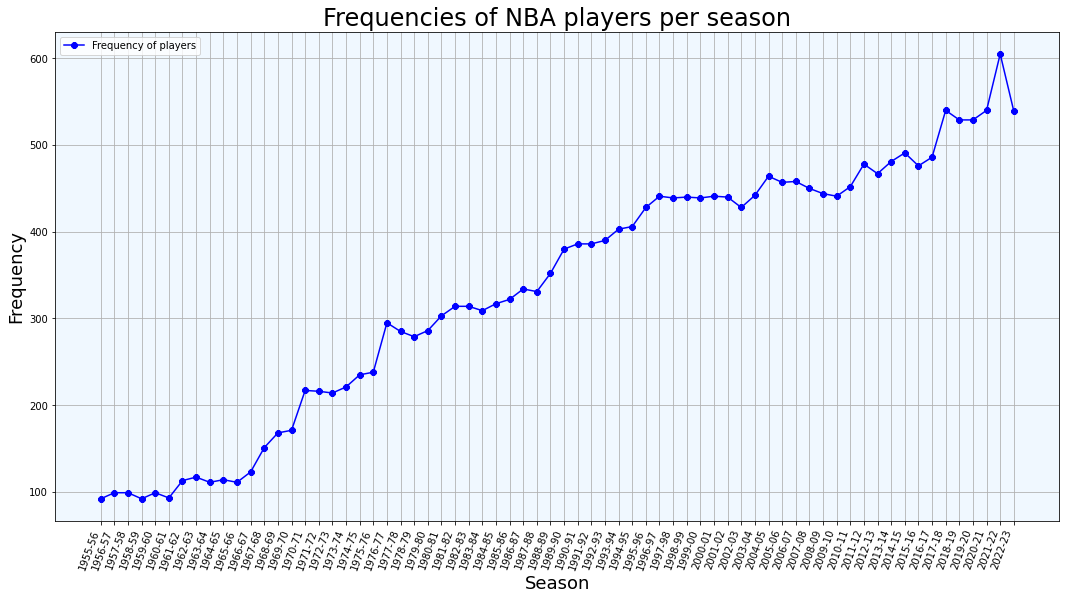

In [23]:
fig, ax = plt.subplots(figsize=(18,9))
freq_players_perseason.plot(ax=ax, marker="8",
                                label="Frequencies of NBA players per season",
                                color='blue')
plt.title('Frequencies of NBA players per season', fontdict ={'size': 24}, loc='center')
plt.ylabel('Frequency', fontdict ={'size': 18})
plt.xlabel('Season',fontdict ={'size': 18})
ax.grid(which='both') #add grid
plt.xticks(rotation=70, ha='right') #rotate xticks
ax.set_facecolor("aliceblue") #setting background color
ax.set_xticklabels(freq_players_perseason.Season) #setting xticks labels
ax.set_xticks(np.arange((freq_players_perseason.shape[0]))) #setting range of xticks 
plt.legend(loc="upper left", labels=['Frequency of players'])
plt.show()

The number of NBA players has risen drastically over time. The games keeps becoming more and more global, making the competition to enter the league even fiercer. Players from all over the world dream to play in the NBA. Also, teams are less reluctant to give opportunities to try out players with 10-day contract and G-league tryouts.

## Teams
Something great about the data is that there is a team value: `TOT` which means that the player has played for more than 1 team. As we can see in the following example, Justice Winslow played for two teams in the 2021-22 season. However, there are 3 rows for that player. One row is for his time with the LA Clippers, one with the Portland Trailer Blazers and one with the stats of both together.

In [24]:
data.loc[(data.Player =='Justise Winslow') & (data.Season =='2021-22')]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,MVP
27154,Justise Winslow,PF,25,TOT,48,11.0,16.1,2.3,5.4,0.428,0.3,1.4,0.227,2.0,4.0,0.497,0.457,0.8,1.4,0.591,1.0,3.2,4.2,1.8,0.7,0.5,1.0,1.4,5.7,2021-22,False
27155,Justise Winslow,PF,25,LAC,37,1.0,13.0,1.7,3.8,0.447,0.1,0.8,0.172,1.6,3.0,0.518,0.465,0.7,1.1,0.610,0.8,2.8,3.6,1.4,0.6,0.5,1.0,1.2,4.2,2021-22,False
27156,Justise Winslow,PF,25,POR,11,10.0,26.8,4.3,10.5,0.405,0.9,3.4,0.270,3.4,7.2,0.468,0.448,1.3,2.3,0.560,1.8,4.5,6.3,2.9,1.3,0.6,1.1,1.9,10.7,2021-22,False


## Games played
Now we will find some stats about the games played. Firstly, the players that played the most games per season. All those players in those seasons played for more than one team


In [25]:
data.sort_values(by=['G'], ascending=False)[['Player','Season','Tm','G']].head(10).reset_index(drop=True)

,Player,Season,Tm,G
0,Walt Bellamy,1968-69,TOT,88
1,Tom Henderson,1976-77,TOT,87
2,McCoy McLemore,1970-71,TOT,86
3,Gar Heard,1975-76,TOT,86
4,Nate Williams,1974-75,TOT,85
5,Howard Komives,1968-69,TOT,85
6,John Tresvant,1967-68,TOT,85
7,Theo Ratliff,2003-04,TOT,85
8,Shareef Abdur-Rahim,2003-04,TOT,85
9,Chris Gatling,1999-00,TOT,85


Next, we will find the players that have played the most games. Firstly, we need to keep one row per player per season, meaning we only keep the average stats of each player for the particular season. Next, we find for each player the number of games he played during the time span

In [26]:
data_no_duplicates = data[['Player','G','Season']].groupby(['Season','Player']).max().reset_index().copy()
data_no_duplicates = pd.merge(data_no_duplicates, data, on=['Season', 'Player','G'])

sum_games_per_player = data_no_duplicates[['Player','G','GS']].groupby(['Player']).sum().reset_index()
sum_games_per_player = sum_games_per_player.sort_values(by=['G'], ascending=False)

Visualizing the results of the top 10 players with the most games played:

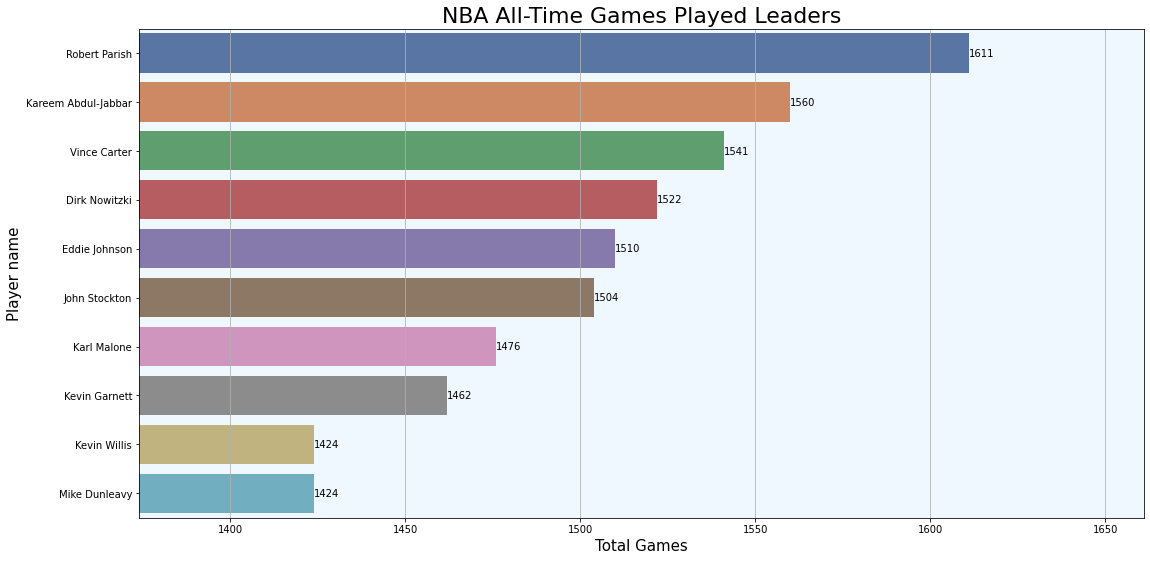

In [27]:
fig_dims = (18, 9) #setting the dimensions of the diagram
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=sum_games_per_player.Player[:10], x=sum_games_per_player.G[:10], palette='deep')
plt.title('NBA All-Time Games Played Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total Games',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
ax.grid(axis='x') #add grid
plt.xlim(sum_games_per_player.iloc[9,sum_games_per_player.columns.get_loc('G')] - 50, 
        sum_games_per_player.iloc[0,sum_games_per_player.columns.get_loc('G')]+ 50)
#setting x axis ranges close to the top 10 players games played
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Games started
Now we create the same diagram for the games started for each player in their career:

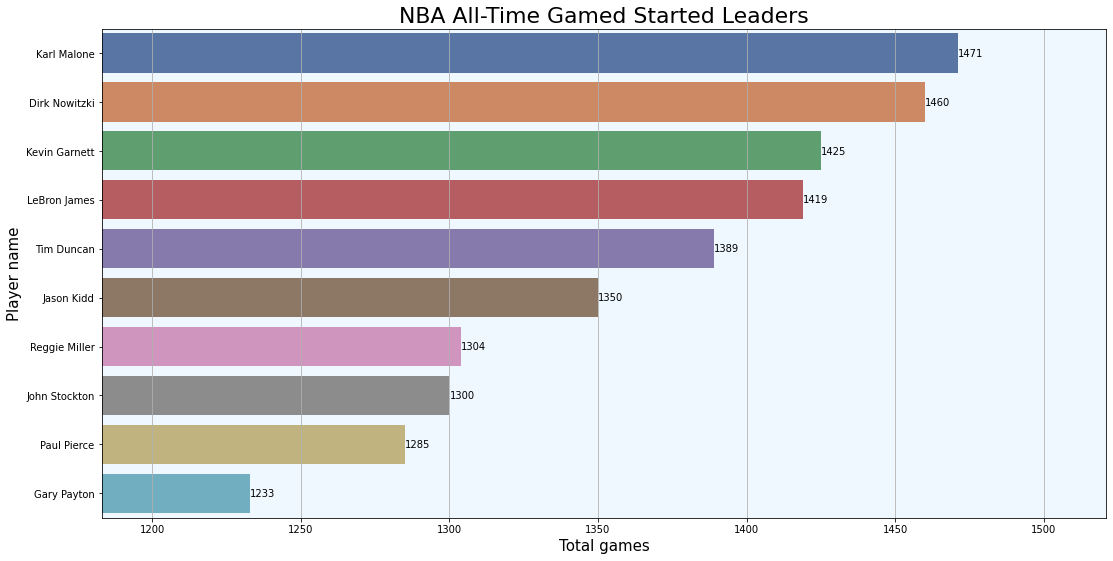

In [28]:
sum_games_per_player = sum_games_per_player.sort_values(by=['GS'], ascending=False) #sorting Df based on games started
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=sum_games_per_player.Player[:10], x=sum_games_per_player.GS[:10], palette='deep')
plt.title('NBA All-Time Gamed Started Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total games',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
ax.grid(axis='x') #add grid
plt.xlim(sum_games_per_player.iloc[9,sum_games_per_player.columns.get_loc('GS')] - 50, 
        sum_games_per_player.iloc[0,sum_games_per_player.columns.get_loc('GS')]+ 50)
#setting x axis ranges close to the top 10 players games started
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Points and three point attempts over the years
Next the evolution of three point shooting and points over the seasons. We will read another webpage from basketball-reference to use that data

In [29]:
season_data = pd.read_html('https://www.basketball-reference.com/leagues/NBA_stats_per_game.html')[0]\
                                                        .droplevel(0, axis = 1)
season_data.drop(season_data[season_data['Rk'] == 'Rk'].index, inplace = True) # removes rows with no valuable information
season_data.drop(season_data[season_data['3PA'] == 'Per Game'].index, inplace = True) # removes rows with no valuable information

season_data['3PA'].fillna(0, inplace=True) #filling Nan values for 3PA
season_data[['3PA','PTS']] = season_data[['3PA','PTS']].apply(pd.to_numeric, errors='ignore') #transform column to numeric

Removing the 2023-24 season due to missing data:

In [30]:
season_data = season_data.loc[season_data.Season != '2023-24'].copy()

Now we reverse the rows of the dataframe so that the years are increasing:

In [31]:
season_data = season_data.iloc[::-1].reset_index(drop=True)

Visualizing the results:

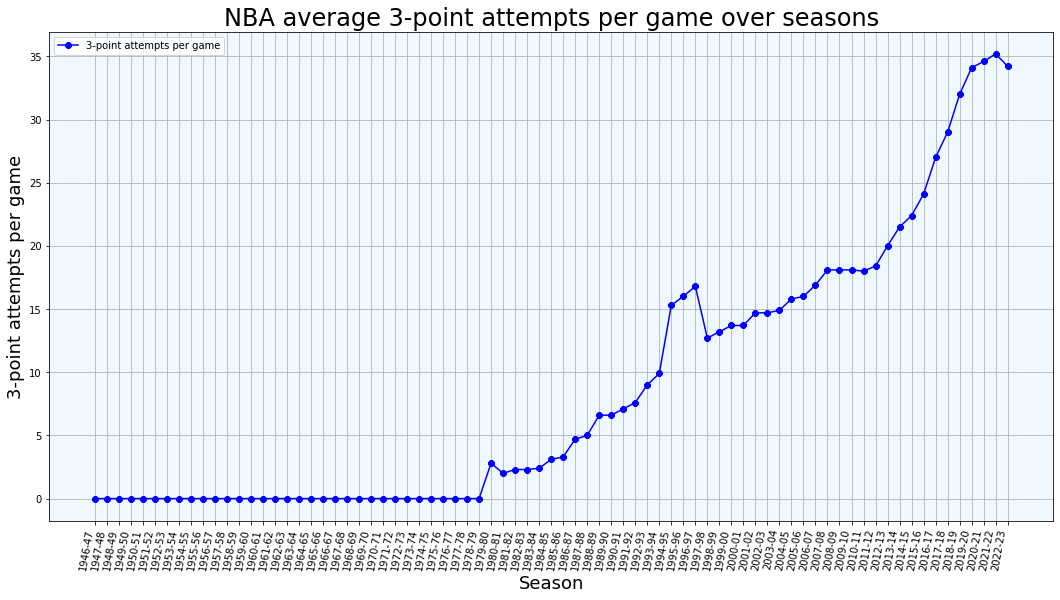

In [32]:
fig, ax = plt.subplots(figsize=(18,9))
season_data[['Season','3PA']].plot(ax=ax, marker="8",
                                label="Three point attempts over time",
                                color='blue')
plt.title('NBA average 3-point attempts per game over seasons', fontdict ={'size': 24}, loc='center')
plt.ylabel('3-point attempts per game', fontdict ={'size': 18})
plt.xlabel('Season',fontdict ={'size': 18})
ax.grid(which='both') #add grid
plt.xticks(rotation=80, ha='right') #rotate xticks
ax.set_facecolor("aliceblue") #setting background color
ax.set_xticklabels(season_data.Season) #setting xticks labels
ax.set_xticks(np.arange((season_data.shape[0]))) #setting range of xticks 
plt.legend(loc="upper left", labels=['3-point attempts per game'])
plt.show()

#### Conclusions
It is visible that there were no 3-point shots scored before the season 1979-80. This makes total sense since the three point line was adopted by the NBA in the 1979-80 season, with Chris Fold scoring the first 3-point shot on the 12th of October 1979. Since then, the 3-point shots keep becoming more and more important and vital for a team's success (the Golden State Warriors are a great example of how the 3-Point shot can be deadly against opponents with them winning multiple championships over the last 10 years). In the 2021-22 season there were the most 3-point attempts per game with more than thirty-five 3-point attempts per game. Last but not least, the 3-point shot is becoming so popular that even power-forwards and centers are adding this skill in their repertoire to bring additional value to their team. The 3-point shot threat is a great way to open up space since defenders can not help one pass away from a shooter (since that could lead to an open and easily scored 3-point shot)

Next the average point per game over the seasons

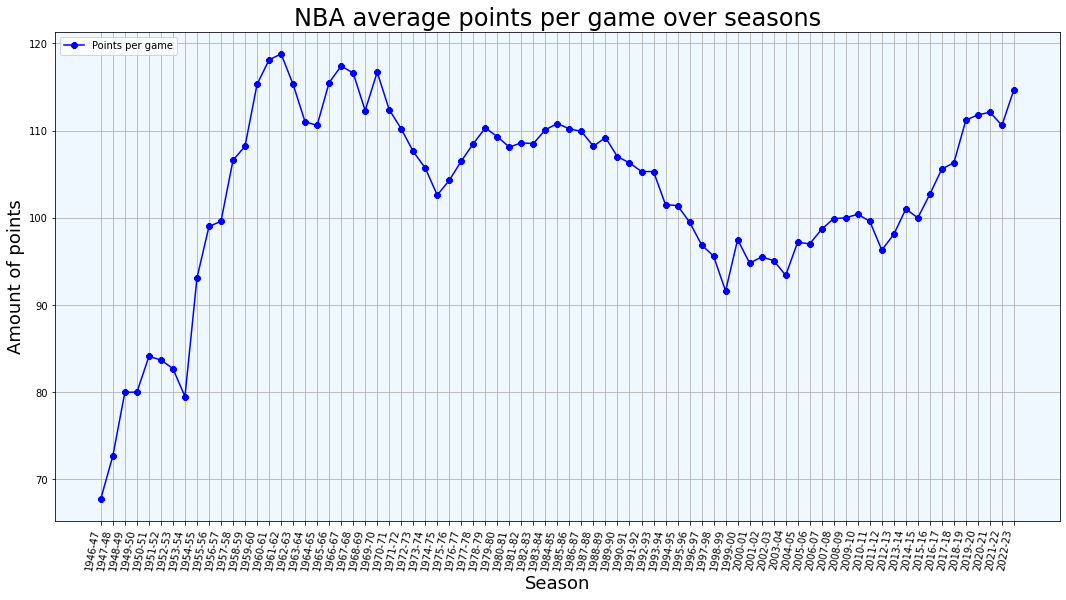

In [33]:
fig, ax = plt.subplots(figsize=(18,9))
season_data[['Season','PTS']].plot(ax=ax, marker="8",
                                label="Points scored over time",
                                color='blue')
plt.title('NBA average points per game over seasons', fontdict ={'size': 24}, loc='center')
plt.ylabel('Amount of points', fontdict ={'size': 18})
plt.xlabel('Season',fontdict ={'size': 18})
ax.grid(which='both') #add grid
plt.xticks(rotation=80, ha='right') #rotate xticks
ax.set_facecolor("aliceblue") #setting background color
ax.set_xticklabels(season_data.Season) #setting xticks labels
ax.set_xticks(np.arange((season_data.shape[0]))) #setting range of xticks 
plt.legend(loc="upper left", labels=['Points per game'])
plt.show()

#### Concusions
Again we can see that the points per game keep increasing from the 2000s and on. This is a combination of the offence becoming more deadly and the defence being less able to stop the offence. As already mentioned, the game is becoming quicker with more possession, more 3-point shots and more early clock offence. On the other side, the adoption of different rules from the NBA, for instance the addition of the hand-checking rule where a defender is prohibited to place and hold an opponent’s hand, made it much harder for defence to contain the offence.

Despite that, the highest-scoring season of all time was recorder in the 1961-62 season when teams averaged 118.8 points per game.

### MVP awards
Next we will find the players with the most mvp awards. We will use `data_no_duplicates` that contain one row per season per season:

In [34]:
mvpawards_per_player = data_no_duplicates[['Player','MVP']].groupby(['Player']).sum().reset_index() 
#summarizing number of mvp awards per player  
mvpawards_per_player = mvpawards_per_player.sort_values(by=['MVP'], ascending=False)

Now we visualize the results:

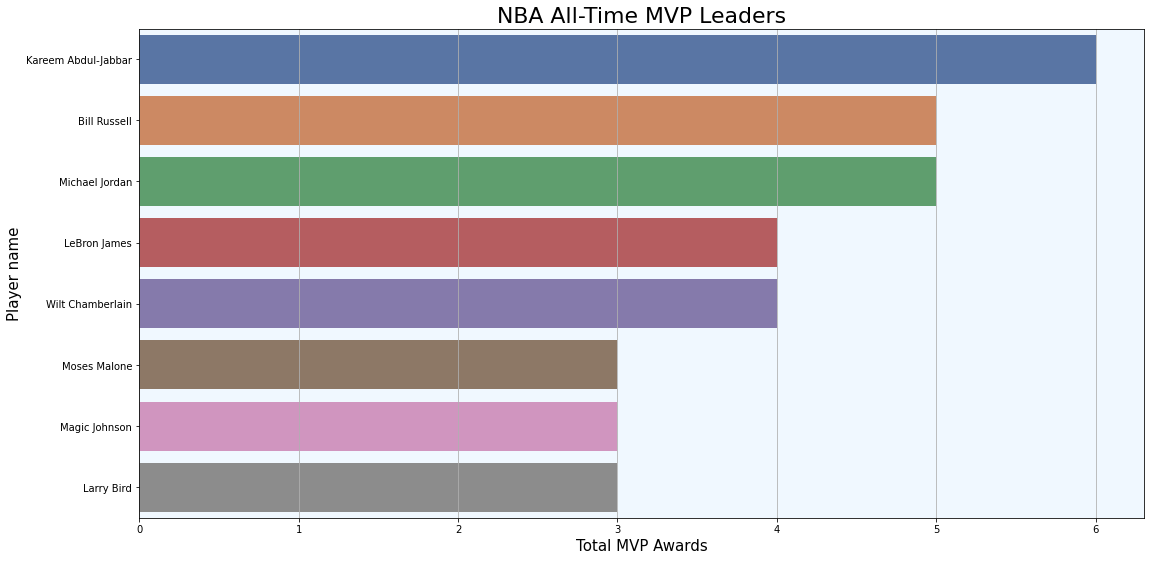

In [35]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=mvpawards_per_player.Player[:8], x=mvpawards_per_player.MVP[:8], palette='deep')
plt.title('NBA All-Time MVP Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total MVP Awards',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
ax.grid(axis='x') #add grid
plt.show()

### Championship data
Firstly, we read another webpage to get information on the players with most championships won:

In [36]:
championships_table = pd.read_html('https://www.basketball-reference.com/leaders/most_championships.html')[0]
championships_table['Player'] = championships_table['Player'].str.strip('*') #removes '*' from name of players
championships_table.rename(columns={'Count':'championships'}, inplace=True)
championships_table['championships'] = championships_table['championships'].apply(pd.to_numeric, errors='ignore') #transform column to numeric

Now we will visualize the NBA championship leaders

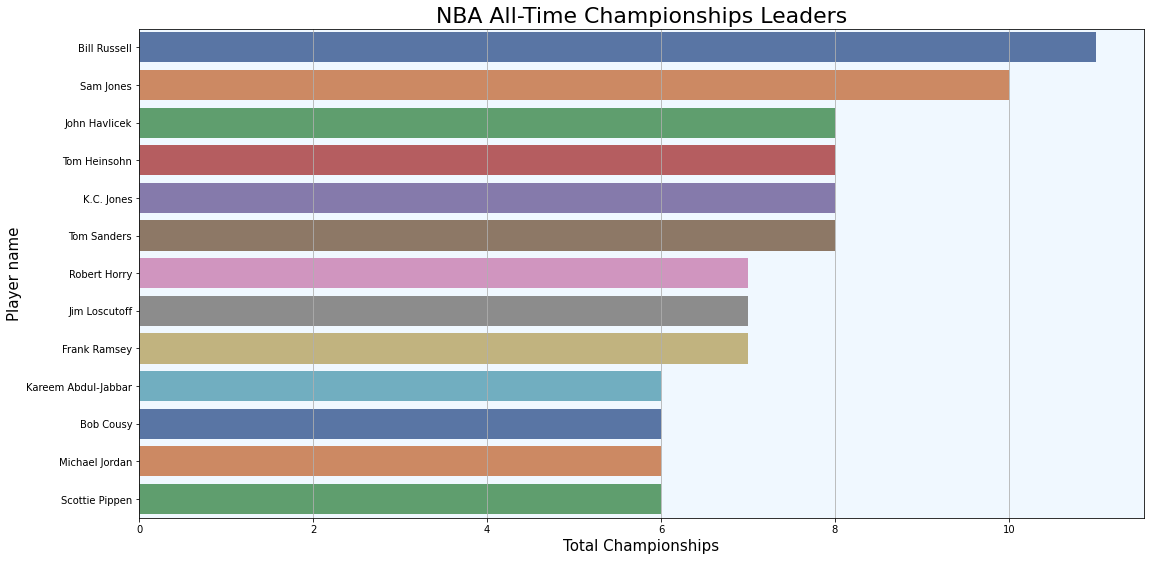

In [37]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=championships_table.Player[:13], x=championships_table.championships[:13], palette='deep')
plt.title('NBA All-Time Championships Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total Championships',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
ax.grid(axis='x') #add grid
plt.show()

### Career data
Next we calculate for each player their sum amount of statistics for the particular season e.g. the sum amount of point, assists,rebounds etc.

In [38]:
attributes_total_list = ['MP','FG','FGA','3P','3PA','TRB','ORB','AST','STL','BLK','TOV','PTS','FT','FTA']
for attribute in attributes_total_list:
    data_no_duplicates['total_' + str(attribute)] = data_no_duplicates[str(attribute)] * data_no_duplicates.G

Next we create a new dataframe that contains the career data for each player:

In [39]:
attributes_career_data = ['Player','G','total_MP','total_FG','total_FGA','total_3P','total_3PA',
                         'total_TRB','total_ORB','total_AST','total_STL','total_BLK','total_TOV','total_PTS',
                         'total_FT','total_FTA','MVP']
career_data = data_no_duplicates[attributes_career_data].groupby(['Player']).sum().reset_index()

### Minutes played
Next we will showcase the players with the most minutes played per single season.

In [40]:
data.sort_values(by=['MP'], ascending=False)[['Player','Season','Tm','MP']].head(10).reset_index(drop=True)

,Player,Season,Tm,MP
0,Wilt Chamberlain,1961-62,PHW,48.5
1,Wilt Chamberlain,1960-61,PHW,47.8
2,Wilt Chamberlain,1962-63,SFW,47.6
3,Wilt Chamberlain,1965-66,PHI,47.3
4,Wilt Chamberlain,1967-68,PHI,46.8
5,Wilt Chamberlain,1959-60,PHW,46.4
6,Wilt Chamberlain,1963-64,SFW,46.1
7,Oscar Robertson,1965-66,CIN,46.0
8,Tiny Archibald,1972-73,KCO,46.0
9,Wilt Chamberlain,1964-65,SFW,45.9


Sorting the data based on the total number of minutes played:

In [41]:
career_data = career_data.sort_values(by=['total_MP'], ascending=False)

Lastly, we are going to visualize the results:

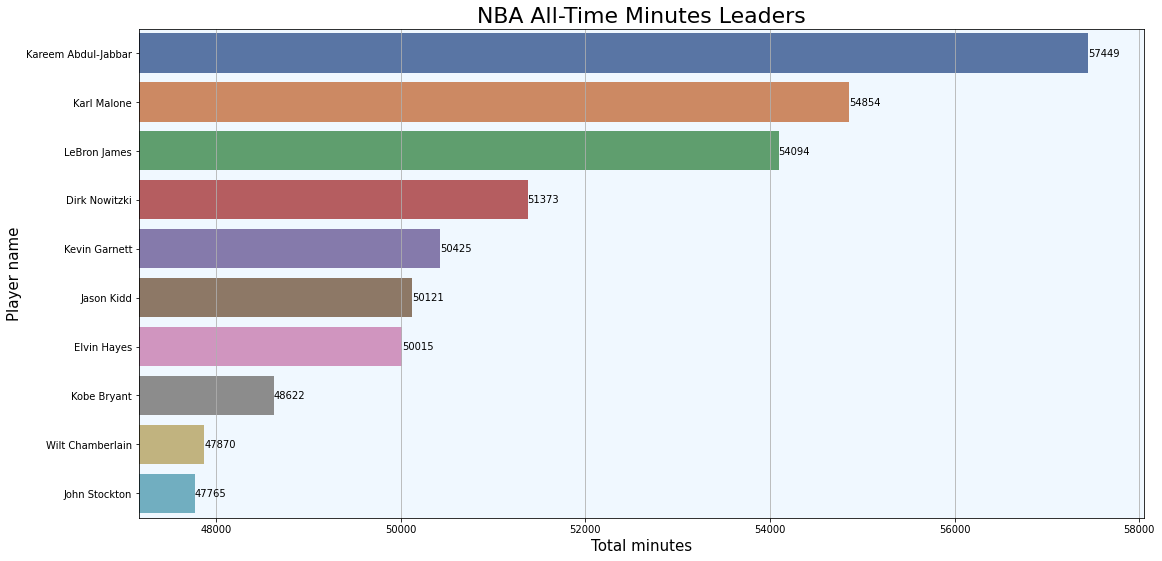

In [42]:
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=career_data.Player[:10], x=career_data.total_MP[:10].round(), palette='deep')
plt.title('NBA All-Time Minutes Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total minutes',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
ax.grid(axis='x') #add grid
plt.xlim(career_data.iloc[9,career_data.columns.get_loc('total_MP')] - 600, 
        career_data.iloc[0,career_data.columns.get_loc('total_MP')]+ 600)
#setting x axis ranges close to the top 10
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Field Goal percentage
Next we will evaluate the field goal percentage. Firstly, we find the players with the highest field goal percentage in a singe season. For that we set a requirement of minimum 40 games played for that player in that specific season: 

In [43]:
data.loc[data.G >= 40].sort_values(by='FG%', ascending=False)[['Player','Season','Tm','FG%']].head(10)\
                                            .reset_index(drop=True)

,Player,Season,Tm,FG%
0,Jericho Sims,2022-23,NYK,0.776
1,DeAndre Jordan,2020-21,BRK,0.763
2,Mitchell Robinson,2021-22,NYK,0.761
3,Mitchell Robinson,2019-20,NYK,0.742
4,Robert Williams,2021-22,BOS,0.736
5,Ryan Hollins,2013-14,LAC,0.736
6,Daniel Gafford,2022-23,WAS,0.732
7,Dwight Powell,2022-23,DAL,0.732
8,Dwight Howard,2019-20,LAL,0.729
9,Wilt Chamberlain,1972-73,LAL,0.727


Now we continue by finding the players with the highest career field goal percentages. We calculate the career percentages and  sort those value and only keep players with minimum 100 games played and minimum 200 field goal attempts. This is a way to make sure that there are no players with extremely high field-goal percentages because they only took very few shots:

In [44]:
career_data['FG%'] = career_data.total_FG / career_data.total_FGA
career_data_FG = career_data.loc[(career_data.G >= 100) & (career_data.total_FG >= 200)]\
                                .sort_values(by='FG%', ascending=False)

Now we can visualize the results:

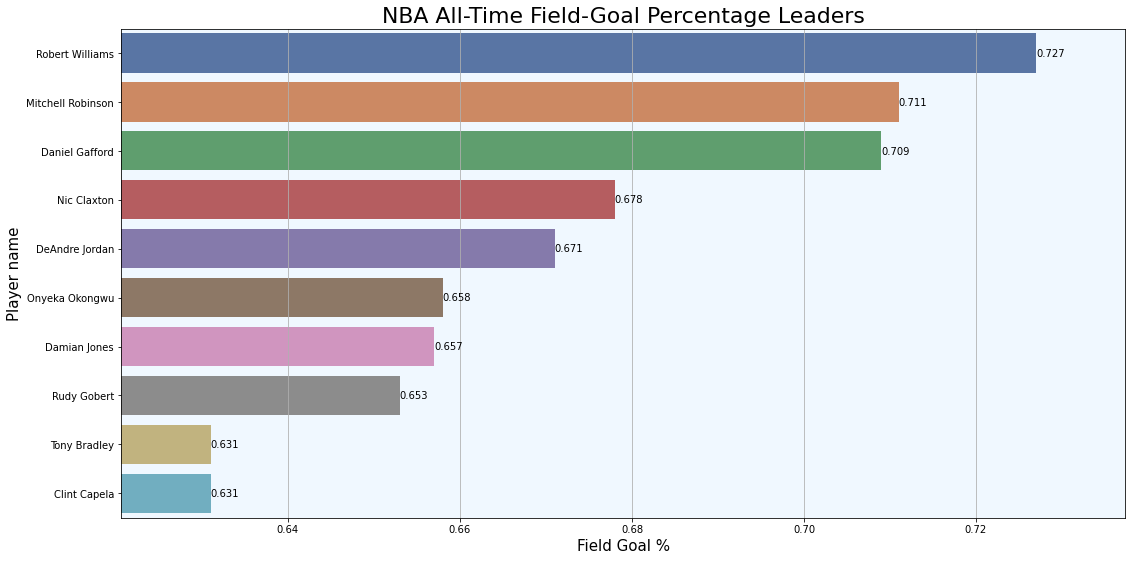

In [45]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data_FG.Player[:10], x=career_data_FG['FG%'][:10].round(3), palette='deep')
plt.title('NBA All-Time Field-Goal Percentage Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Field Goal %',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
ax.grid(axis='x') #add grid
plt.xlim(career_data_FG.iloc[9,career_data_FG.columns.get_loc('FG%')] - 0.01, 
        career_data_FG.iloc[0,career_data_FG.columns.get_loc('FG%')]+ 0.01)
#setting x axis ranges close to the percentage
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### 3 Point
Now we will focus on the 3 point statistics. Firstly show the players with the highest 3 point percentage for a single season, minimum 40 games played and minimum one 3point attempt on average per game:

In [46]:
data.loc[(data.G >= 40) & (data['3PA'] > 1)].sort_values(by='3P%', ascending=False)[['Player','Season','Tm','3P%']]\
                                                                                    .head(10).reset_index(drop=True)

,Player,Season,Tm,3P%
0,Tony Snell,2020-21,ATL,0.569
1,Pau Gasol,2016-17,SAS,0.538
2,Kyle Korver,2009-10,UTA,0.536
3,Steve Kerr,1994-95,CHI,0.524
4,Tim Legler,1995-96,WSB,0.522
5,Jon Sundvold,1988-89,MIA,0.522
6,Steve Kerr,1995-96,CHI,0.515
7,Detlef Schrempf,1994-95,SEA,0.514
8,Jason Kapono,2006-07,MIA,0.514
9,Luke Babbitt,2014-15,NOP,0.513


Now we summarize the data and sort the values to find the players the highest 3 point percentages, minimum 100 games played and 200 3 point attempts:

In [47]:
career_data['3P%'] = career_data.total_3P / career_data.total_3PA
career_data_3P = career_data.loc[(career_data.G >= 100) & (career_data.total_3PA >= 200)]\
                                .sort_values(by='3P%', ascending=False)

Now we visualize the results

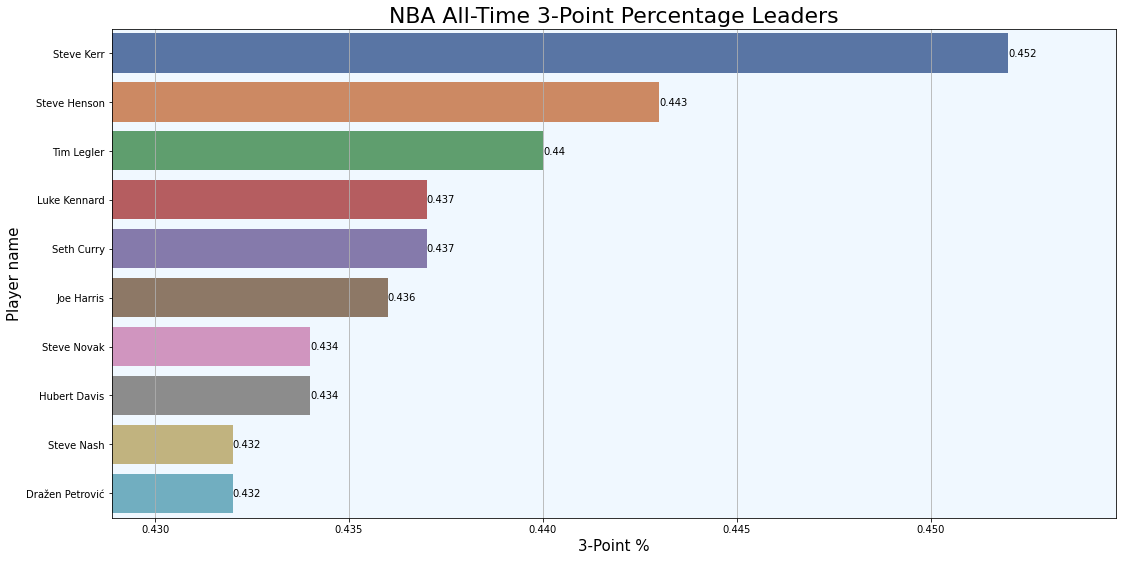

In [48]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data_3P.Player[:10], x=career_data_3P['3P%'][:10].round(3), palette='deep')
plt.title('NBA All-Time 3-Point Percentage Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('3-Point %',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data_3P.iloc[9, career_data_3P.columns.get_loc('3P%')] - 0.003,
         career_data_3P.iloc[0, career_data_3P.columns.get_loc('3P%')]+ 0.003) 
#setting x axis ranges to the limits of the top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

Now we focus on the players with the most 3 pointers scored

In [49]:
career_data_3P = career_data_3P.sort_values(by='total_3P', ascending=False)

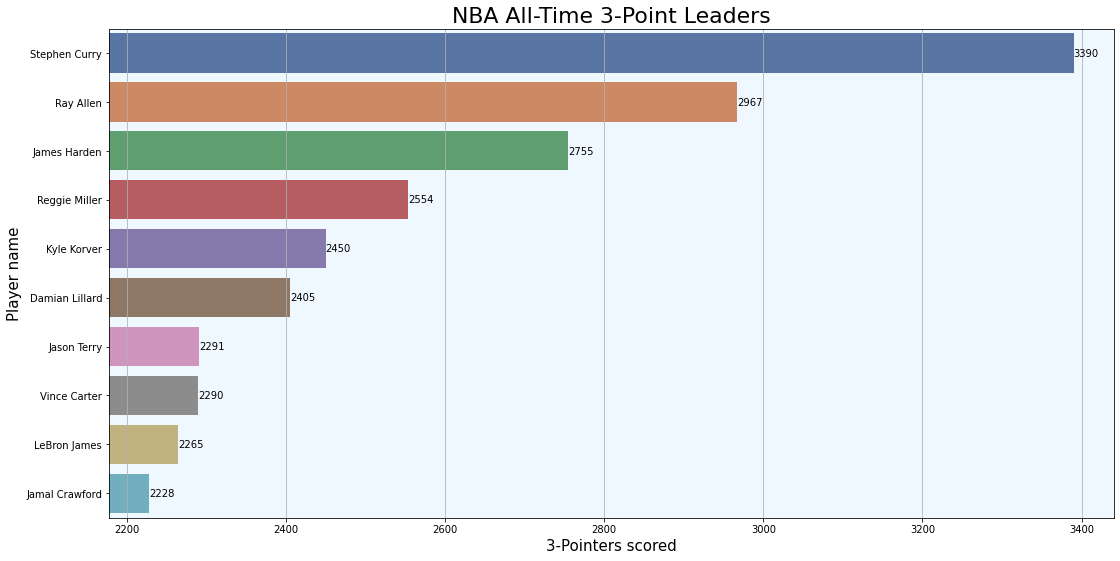

In [50]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data_3P.Player[:10], x=career_data_3P['total_3P'][:10].round(), palette='deep')
plt.title('NBA All-Time 3-Point Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('3-Pointers scored',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data_3P.iloc[9, career_data_3P.columns.get_loc('total_3P')] - 50,
         career_data_3P.iloc[0, career_data_3P.columns.get_loc('total_3P')]+ 50) 
#setting x axis ranges close to the limits of the top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Free throws
Next we will check the free throws. Firstly, the players with the most average free throws scored per game in a single season, minimum 40 games played per season.

In [51]:
data.loc[data.G > 40].sort_values(by='FT', ascending=False)[['Player','Tm','Season','FT']]\
                                                            .head(10).reset_index(drop=True)

,Player,Tm,Season,FT
0,Jerry West,LAL,1965-66,10.6
1,Wilt Chamberlain,PHW,1961-62,10.4
2,Adrian Dantley,UTA,1983-84,10.3
3,James Harden,HOU,2019-20,10.2
4,Michael Jordan,CHI,1986-87,10.2
5,Oscar Robertson,CIN,1963-64,10.1
6,Joel Embiid,PHI,2022-23,10.0
7,Elgin Baylor,LAL,1961-62,9.9
8,Shai Gilgeous-Alexander,OKC,2022-23,9.8
9,Oscar Robertson,CIN,1965-66,9.8


Next we will see the players with the best free throw percentages for a single season, minimum 40 games played and 1 free throw attemp per game

In [52]:
data.loc[(data.G > 40) & (data.FTA > 1)].sort_values(by='FT%', ascending=False)[['Player','Tm','Season','FT%']]\
                                                                    .head(10).reset_index(drop=True)

,Player,Tm,Season,FT%
0,José Calderón,TOR,2008-09,0.981
1,Calvin Murphy,HOU,1980-81,0.958
2,Mahmoud Abdul-Rauf,DEN,1993-94,0.956
3,Ray Allen,BOS,2008-09,0.952
4,Jeff Hornacek,UTA,1999-00,0.950
5,Mark Price,CLE,1992-93,0.948
6,Rick Barry,HOU,1978-79,0.947
7,Mark Price,CLE,1991-92,0.947
8,Ernie DiGregorio,BUF,1976-77,0.945
9,J.J. Redick,TOT,2020-21,0.942


Now the free throw percentage is calculated. Lastly, only the players with minmum 100 games played and 200 free throw attempts are considered

In [53]:
career_data['FT%'] = career_data.total_FT / career_data.total_FTA
career_data_FT = career_data.loc[(career_data.G >= 100) &(career_data.total_FTA >= 200)]\
                                .sort_values(by='FT%', ascending=False)

Visualizing the results

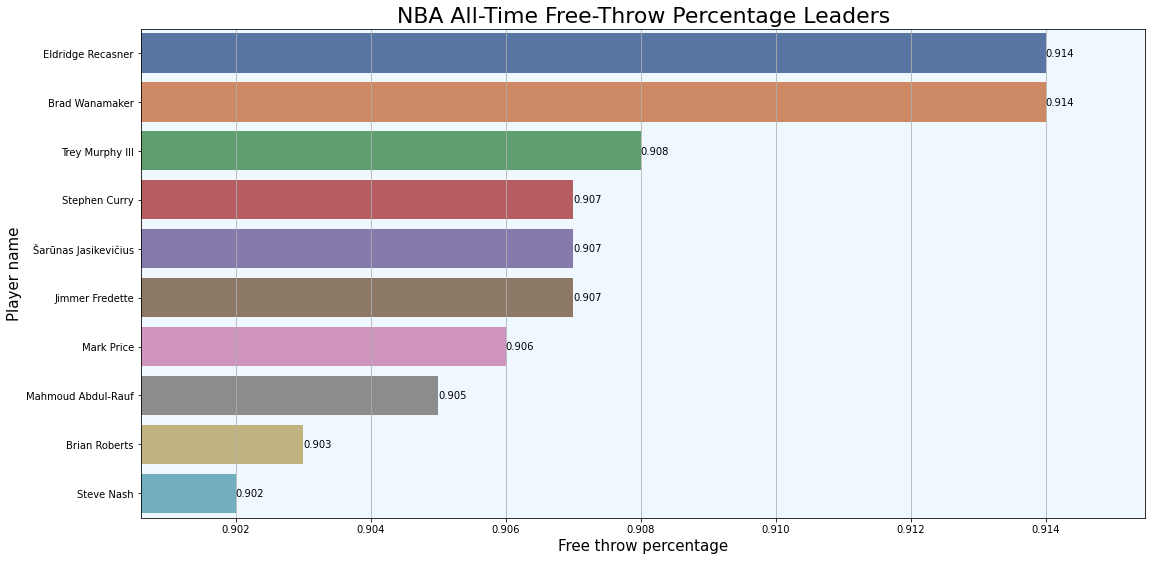

In [54]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data_FT.Player[:10], x=career_data_FT['FT%'][:10].round(3), palette='deep')
plt.title('NBA All-Time Free-Throw Percentage Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Free throw percentage',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data_FT.iloc[9, career_data_FT.columns.get_loc('FT%')] - 0.001,
         career_data_FT.iloc[0, career_data_FT.columns.get_loc('FT%')]+ 0.001) 
#setting x axis ranges close to the limits of the top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Rebounds
Now its time for the best rebounders. We will check the best rebounding seasons, minimum 40 games played:

In [55]:
data.loc[data.G >= 40].sort_values(by='TRB', ascending=False)[['Player','Tm','Season','TRB']]\
                                                    .head(10).reset_index(drop=True)

,Player,Tm,Season,TRB
0,Wilt Chamberlain,PHW,1960-61,27.2
1,Wilt Chamberlain,PHW,1959-60,27.0
2,Wilt Chamberlain,PHW,1961-62,25.7
3,Bill Russell,BOS,1963-64,24.7
4,Wilt Chamberlain,PHI,1965-66,24.6
5,Wilt Chamberlain,SFW,1962-63,24.3
6,Wilt Chamberlain,PHI,1966-67,24.2
7,Bill Russell,BOS,1964-65,24.1
8,Bill Russell,BOS,1959-60,24.0
9,Bill Russell,BOS,1960-61,23.9


Visualizing the results:

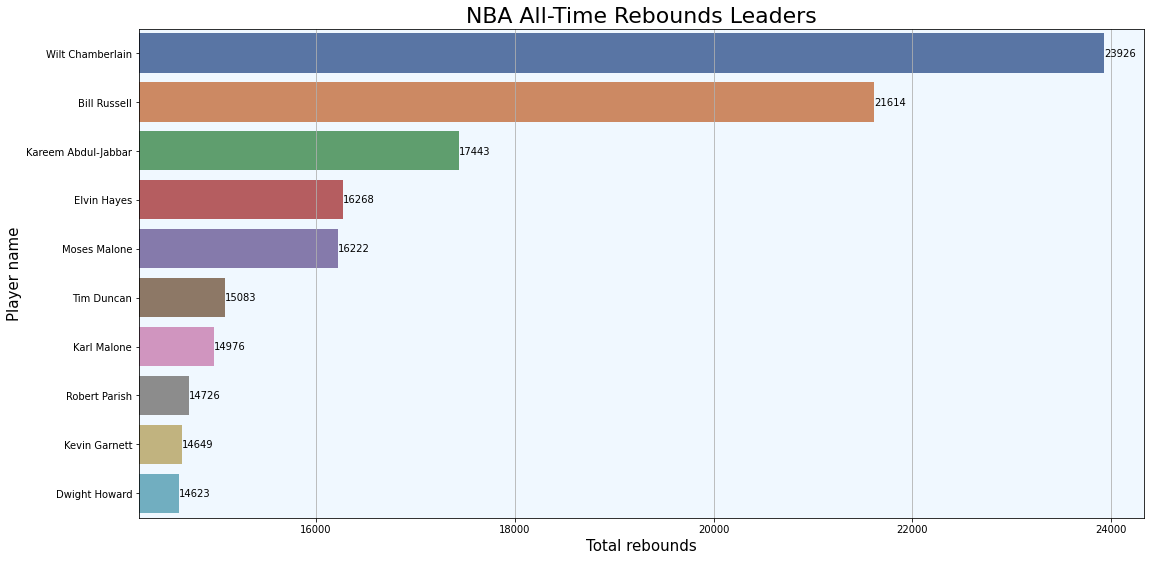

In [56]:
career_data = career_data.sort_values(by='total_TRB', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_TRB'][:10].round(), palette='deep')
plt.title('NBA All-Time Rebounds Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total rebounds',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9, career_data.columns.get_loc('total_TRB')] - 400, 
         career_data.iloc[0, career_data.columns.get_loc('total_TRB')]+ 400) 
#setting x axis ranges close to the limits of the top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

Now offensive rebounds:

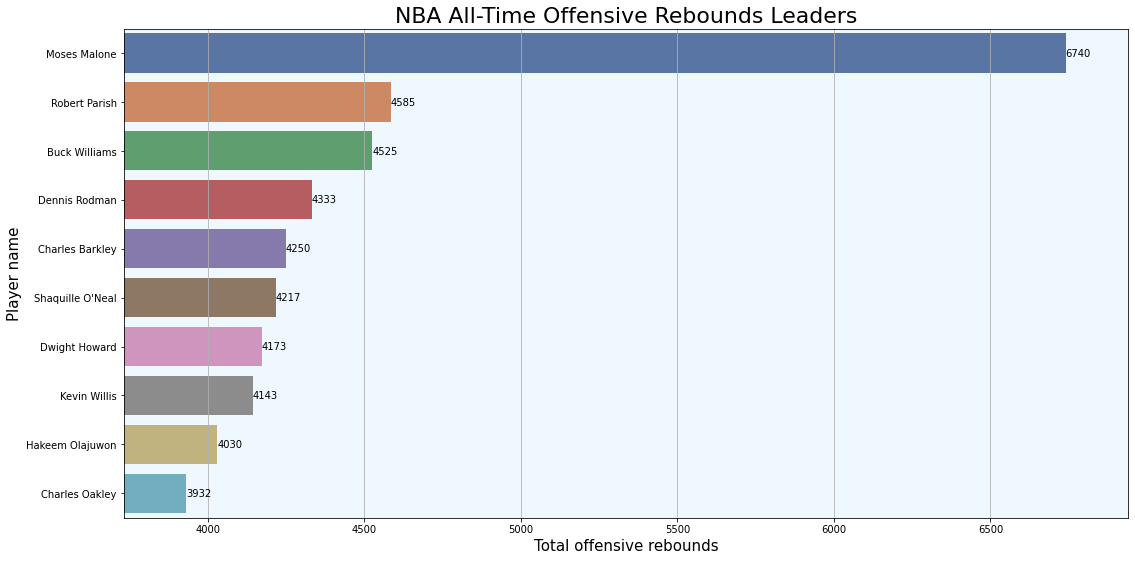

In [57]:
career_data = career_data.sort_values(by='total_ORB', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_ORB'][:10].round(), palette='deep')
plt.title('NBA All-Time Offensive Rebounds Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total offensive rebounds',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9, career_data.columns.get_loc('total_ORB')] - 200, 
         career_data.iloc[0, career_data.columns.get_loc('total_ORB')]+ 200) 
#setting x axis ranges close to the limits of top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Assists
Now it is time to analyze the assist. Firstly, the players with the highest assist per game in a single season, minimum 40 games. In case of a tie, the player that has played in more games outdoes his competitor:

In [58]:
data.loc[data.G >= 40].sort_values(['AST','G'], ascending=False)[['Player','Tm','Season','AST']]\
                                                                        .head(10).reset_index(drop=True)

,Player,Tm,Season,AST
0,John Stockton,UTA,1989-90,14.5
1,John Stockton,UTA,1990-91,14.2
2,Isiah Thomas,DET,1984-85,13.9
3,John Stockton,UTA,1987-88,13.8
4,John Stockton,UTA,1991-92,13.7
5,John Stockton,UTA,1988-89,13.6
6,Kevin Porter,DET,1978-79,13.4
7,Magic Johnson,LAL,1983-84,13.1
8,Magic Johnson,LAL,1988-89,12.8
9,John Stockton,UTA,1993-94,12.6


Visualizing the career assists:

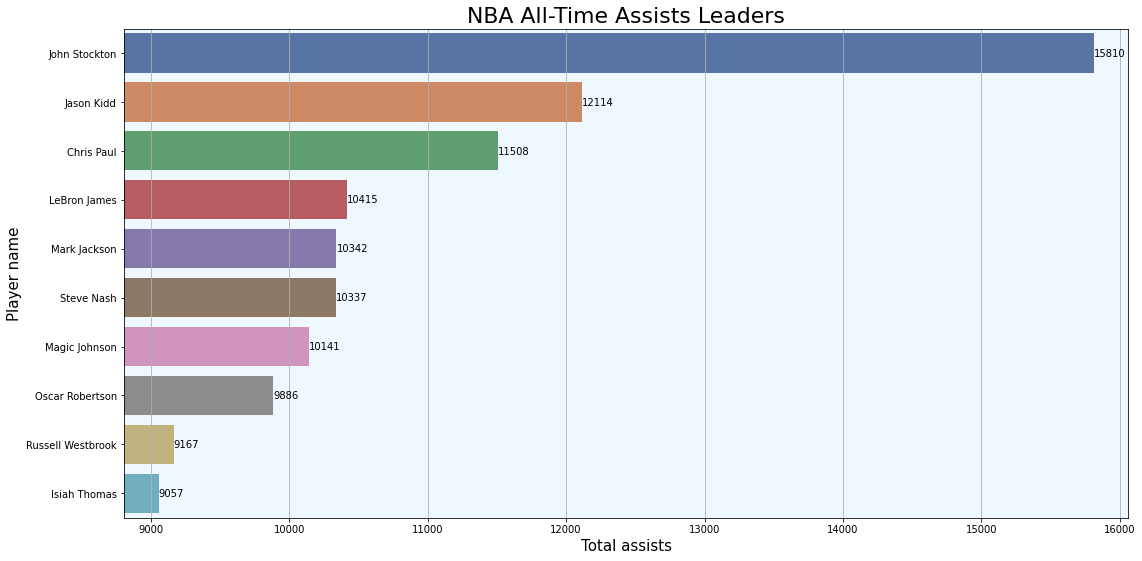

In [59]:
career_data = career_data.sort_values(by='total_AST', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_AST'][:10].round(), palette='deep')
plt.title('NBA All-Time Assists Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total assists',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9, career_data.columns.get_loc('total_AST')] - 250, 
         career_data.iloc[0, career_data.columns.get_loc('total_AST')]+ 250) 
#setting x axis ranges close to the limits of top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Steals
Next up steals. Firstly, the highest steals per game in a single season, with a minimum of 40 games played:

In [60]:
data.loc[data.G >= 40].sort_values(['STL','G'], ascending=False)[['Player','Tm','Season','STL']]\
                                                                        .head(10).reset_index(drop=True)

,Player,Tm,Season,STL
0,Alvin Robertson,SAS,1985-86,3.7
1,Don Buse,IND,1976-77,3.5
2,Slick Watts,SEA,1975-76,3.2
3,Micheal Ray Richardson,NYK,1979-80,3.2
4,Michael Jordan,CHI,1987-88,3.2
5,John Stockton,UTA,1988-89,3.2
6,Alvin Robertson,SAS,1986-87,3.2
7,Micheal Ray Richardson,NJN,1984-85,3.0
8,Alvin Robertson,SAS,1987-88,3.0
9,John Stockton,UTA,1987-88,3.0


Now the results:

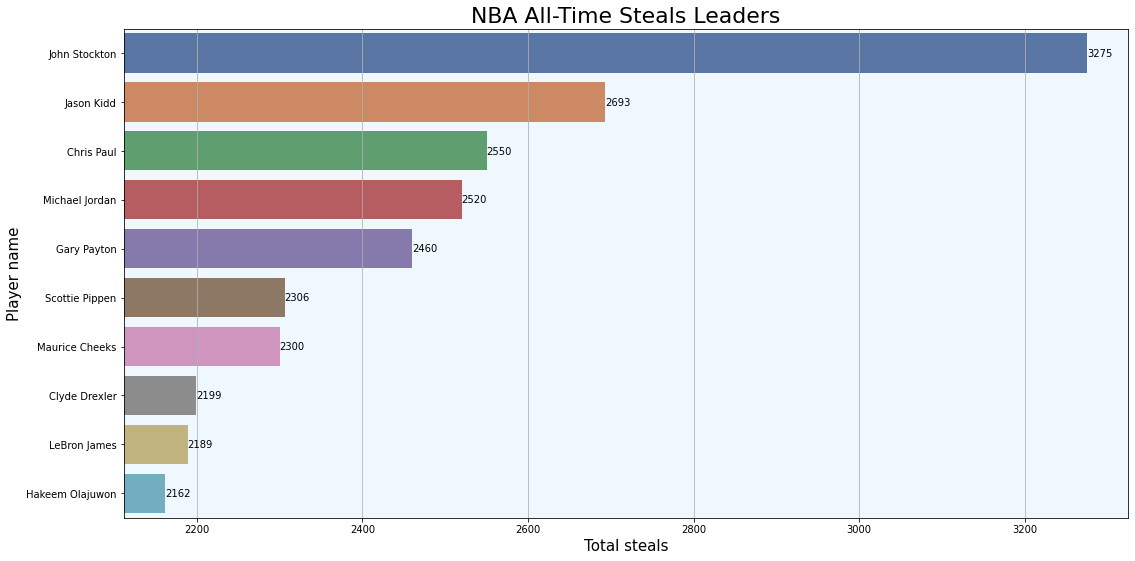

In [61]:
career_data = career_data.sort_values(by='total_STL', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_STL'][:10].round(), palette='deep')
plt.title('NBA All-Time Steals Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total steals',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9, career_data.columns.get_loc('total_STL')] - 50, 
         career_data.iloc[0, career_data.columns.get_loc('total_STL')]+ 50) 
#setting x axis ranges close to the limits of top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Blocks
Next up blocks. Firstly, the highest blocks per game in a single season, with a minimum of 40 games played:

In [62]:
data.loc[data.G >= 40].sort_values(['BLK','G'], ascending=False)[['Player','Tm','Season','BLK']]\
                                                                            .head(10).reset_index(drop=True)

,Player,Tm,Season,BLK
0,Mark Eaton,UTA,1984-85,5.6
1,Manute Bol,WSB,1985-86,5.0
2,Elmore Smith,LAL,1973-74,4.9
3,Hakeem Olajuwon,HOU,1989-90,4.6
4,Mark Eaton,UTA,1985-86,4.6
5,Dikembe Mutombo,DEN,1995-96,4.5
6,David Robinson,SAS,1991-92,4.5
7,Mark Eaton,UTA,1983-84,4.3
8,Tree Rollins,ATL,1982-83,4.3
9,Manute Bol,GSW,1988-89,4.3


Lets check the top 10 blockers:

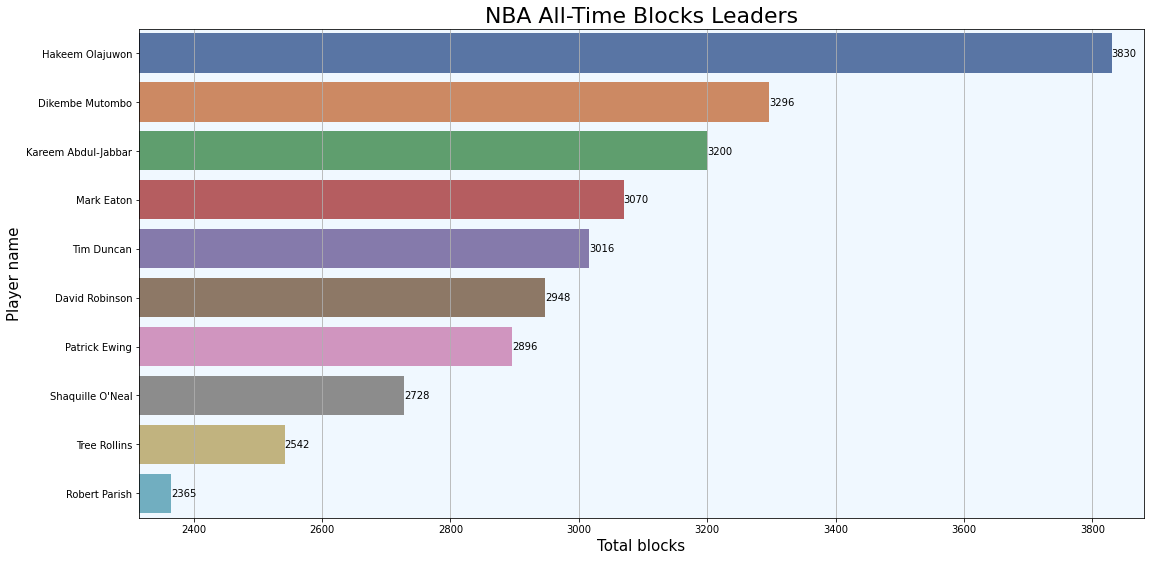

In [63]:
career_data = career_data.sort_values(by='total_BLK', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_BLK'][:10].round(), palette='deep')
plt.title('NBA All-Time Blocks Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total blocks',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9,career_data.columns.get_loc('total_BLK')] - 50, 
         career_data.iloc[0, career_data.columns.get_loc('total_BLK')]+ 50) 
#setting x axis ranges close to the limits of top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Points
Next up points. Firstly, the highest points per game in a single season, with a minimum of 40 games played:

In [64]:
data.loc[data.G >= 40].sort_values(['PTS','G'], ascending=False)[['Player','Tm','Season','PTS','G']]\
                                                                    .head(10).reset_index(drop=True)

,Player,Tm,Season,PTS,G
0,Wilt Chamberlain,PHW,1961-62,50.4,80
1,Wilt Chamberlain,SFW,1962-63,44.8,80
2,Wilt Chamberlain,PHW,1960-61,38.4,79
3,Elgin Baylor,LAL,1961-62,38.3,48
4,Wilt Chamberlain,PHW,1959-60,37.6,72
5,Michael Jordan,CHI,1986-87,37.1,82
6,Wilt Chamberlain,SFW,1963-64,36.9,80
7,James Harden,HOU,2018-19,36.1,78
8,Rick Barry,SFW,1966-67,35.6,78
9,Kobe Bryant,LAL,2005-06,35.4,80


Now lets visualize the top 10 all time scorers:

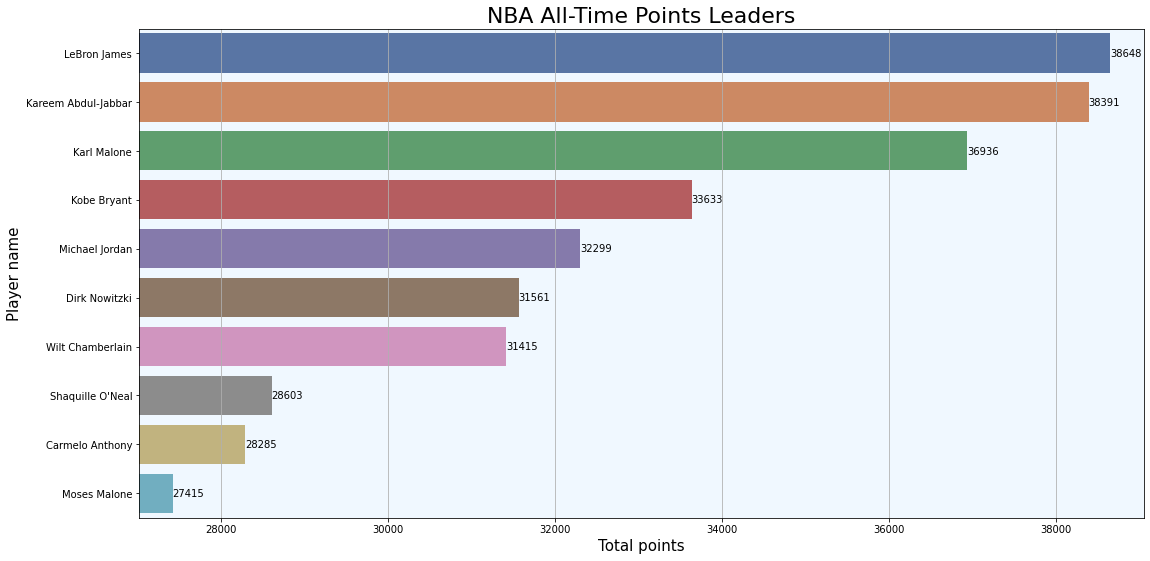

In [65]:
career_data = career_data.sort_values(by='total_PTS', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_PTS'][:10].round(), palette='deep')
plt.title('NBA All-Time Points Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total points',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9, career_data.columns.get_loc('total_PTS')] - 400, 
         career_data.iloc[0, career_data.columns.get_loc('total_PTS')]+ 400) 
#setting x axis ranges close to the limits of top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

### Turnovers
Now lets check the players with highest turnovers per game in a single season, minimum 40 games played

In [66]:
data.loc[data.G >= 40].sort_values(['TOV','G'], ascending=False)[['Player','Tm','Season','TOV','G']]\
                                                                            .head(10).reset_index(drop=True)

,Player,Tm,Season,TOV,G
0,James Harden,HOU,2016-17,5.7,81
1,Russell Westbrook,OKC,2016-17,5.4,81
2,James Harden,HOU,2018-19,5.0,78
3,Pete Maravich,NOJ,1977-78,5.0,50
4,DeMarcus Cousins,NOP,2017-18,5.0,48
5,Russell Westbrook,OKC,2017-18,4.8,80
6,Russell Westbrook,WAS,2020-21,4.8,65
7,Trae Young,ATL,2019-20,4.8,60
8,James Harden,BRK,2021-22,4.8,44
9,Kevin Porter,NJN,1977-78,4.7,74


Next we will calculate the players with most turnovers in nba history:

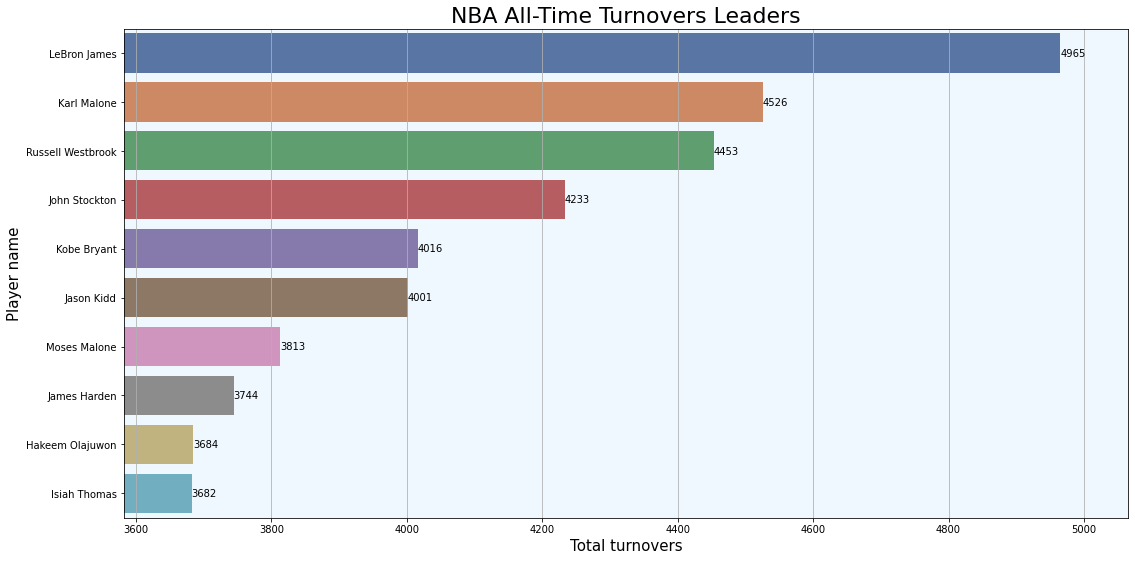

In [67]:
career_data = career_data.sort_values(by='total_TOV', ascending=False) #sorting values
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=career_data.Player[:10], x=career_data['total_TOV'][:10].round(), palette='deep')
plt.title('NBA All-Time Turnovers Leaders', fontdict ={'size': 22})
plt.ylabel('Player name', fontdict ={'size': 15})
plt.xlabel('Total turnovers',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xlim(career_data.iloc[9, career_data.columns.get_loc('total_TOV')] - 100,
         career_data.iloc[0, career_data.columns.get_loc('total_TOV')]+ 100) 
##setting x axis ranges close to the limits of top 10
ax.grid(axis='x') #add grid
for i in ax.containers: #printing values next to bars
    ax.bar_label(i)
plt.show()

The total number of any stats for players may differ +/- 5 since it's is calculated from the seasonal per-game average data. For example, Karl Malone has commited 4524 total turnovers instead of 4526.

### All time great players career stats comparison
We will use a radar plot in order to compare the top players. Firstly, a function script is re-used for the visualizations 

In [68]:
def radar_factory(keys, values, title, axes=None, fontsize=12):
    
    import math
    
    if axes is None:
        # Initialise the spider plot.
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, polar=True)
    else:
        ax = axes
        
    num_categories = len(keys)
 
    # What will be the angle of each axis in the plot? 
    # We divide the plot / number of variables + 1.
    # We add one because we want to do a complete circle.
    angles = np.arange(num_categories + 1)
    angles = angles / num_categories * 2 * np.pi 
    angles[-1] = angles[0]
 
    # We want the first axis to be on top.
    ax.set_theta_offset(np.pi / 2)
    # Theta direction is -1 clockwise,
    # and 1 counterclockwise
    ax.set_theta_direction(-1)
 
    # Draw one axis per variable and add x labels
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(keys)
 
    # Draw y labels
    ax.set_rlabel_position(0)

    values.append(values[0])
    ax.plot(list(angles), values, 
            linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)
    yticks = ax.get_yticks()
    ax.set_yticklabels([])
    ylims = ax.get_ylim()
    
    max_y = 1 #max value due to MinMaxScaler()
    min_y = 0 #min value due to MinMaxScaler()
    ax.set_ylim(min_y, 
               max_y)
    ax.set_title(title,{'fontweight':'bold'})

We only keep players that have played a minimum of 300 games and attempted 600 field goal attempts

In [69]:
career_data_minimum_standards = career_data.loc[(career_data.G >= 300) & (career_data.total_FGA >= 600)].copy()

Now we merge the `championships_table` data into the career dataframe:

In [70]:
career_data_minimum_standards = pd.merge(career_data_minimum_standards, 
                                         championships_table[['Player','championships']], 
                                         on=['Player'], how='left')


Because some of the all time greats have not won any championships or very few, we manually enter those values:

In [71]:
career_data_minimum_standards.loc[career_data_minimum_standards.Player == 'Wilt Chamberlain', 'championships'] = 2
career_data_minimum_standards.loc[career_data_minimum_standards.Player == 'Karl Malone', 'championships'] = 0
career_data_minimum_standards.loc[career_data_minimum_standards.Player == 'Hakeem Olajuwon', 'championships'] = 2
career_data_minimum_standards.loc[career_data_minimum_standards.Player == 'John Stockton', 'championships'] = 0
career_data_minimum_standards.loc[career_data_minimum_standards.Player == 'Kevin Durant', 'championships'] = 2

Next, because the career data attributes (points, assists, blocks etc.) vary a lot, we have to set a common scale for all. We will use MinMaxScaler in order to transform all the data in the interval [0,1]. That means that the maximum value for one column (e.g. LeBron James total 38648 points will be scaled down to 1 and the minimum value of total points will be scaled to 0). In that way all the attributes will have the same scale, which allows the mutual visualization.

In [72]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

career_data_columns = ['total_PTS','total_FG','total_3P','total_FT','total_AST','total_TRB','total_STL','total_BLK',
                      'total_TOV', 'MVP', 'championships'] #columns that we are interested

X = scaler.fit_transform(career_data_minimum_standards[career_data_columns]) #scaling data
scaled_career_data = pd.DataFrame(X, index=career_data_minimum_standards.index, 
                             columns=career_data_columns) #creating a new dataframe
scaled_career_data = scaled_career_data.join(career_data_minimum_standards.Player) #adding the player names

Next we can define the column names that we want to showcase on the radar plot and the all time greats that we are interested in:

In [73]:
columns_names_shown = ['PTS','FG','3P','FT','AST','REB','STL','BLK',
                       'TOV','MVP', 'CHIPS']
all_time_greats = ['Kobe Bryant','LeBron James','Michael Jordan',"Shaquille O'Neal",
                   'Kareem Abdul-Jabbar','Karl Malone','Bill Russell', 'Wilt Chamberlain',
                   'Magic Johnson','Larry Bird', 'Hakeem Olajuwon',
                    'John Stockton','Tim Duncan','Stephen Curry','Kevin Durant']

Next we use a script to visualize the radar plots of the all time greats, next to each other:

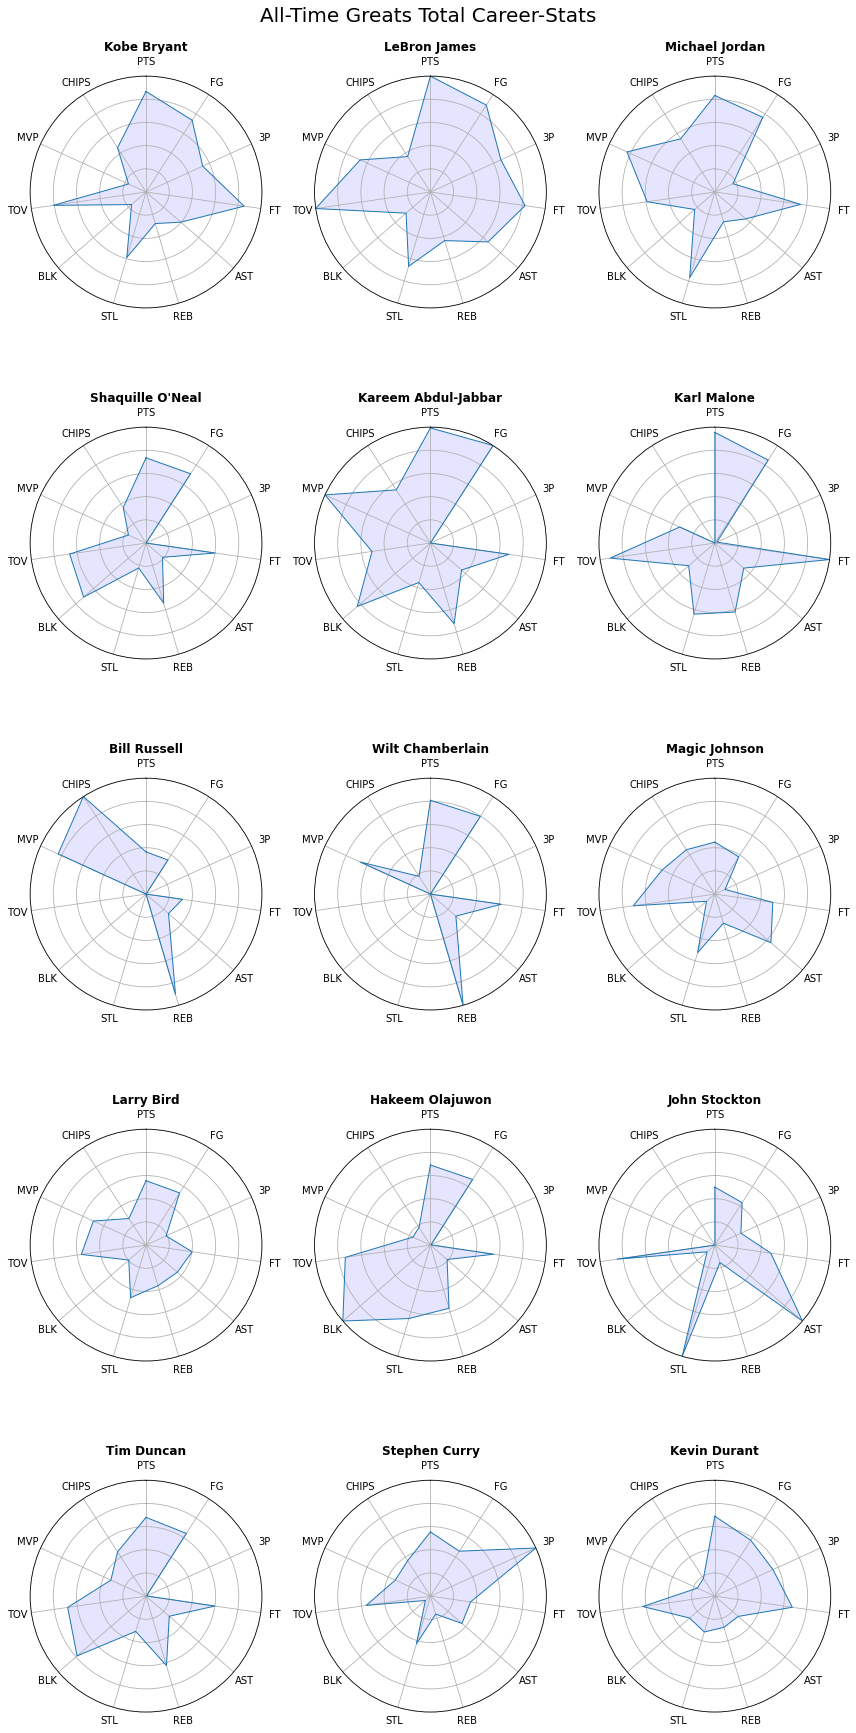

In [74]:
fig = plt.figure(figsize=(12, 25))
for i, player in enumerate(all_time_greats):
    ax = plt.subplot(5, 3, i + 1, polar=True)
    scaled_player_data = scaled_career_data.loc[scaled_career_data.Player == str(player)].copy()
    radar_factory(columns_names_shown,
                  list(scaled_player_data[career_data_columns].values[0]), 
                  player, axes=ax, fontsize=10)
fig.suptitle('All-Time Greats Total Career-Stats', fontsize=20, fontweight='light')
fig.tight_layout() #removes empty space under title
plt.show()

#### Conclusion
Those plots are great to see where each of the all-time great players dominated during their careers. As a result, it is a great way to compare the unique career achievements when it comes to the different basketball statistics. However, some players have played less games than the others, for example Michael Jordan retired from basketball for 2 years only to come back and dominate again. This is why, this visualization does not tell the whole story on who is the basketball greatest athlete. However these visualizations could show the greatest NBA career when it comes to longevity. Lebrong James and Kareem Abdul-Jabbar have had the greatest NBA careers.

### All time great players per game stats comparison
Next we will find the average stats per game for every players and save them in new columns

In [75]:
column_names_pergame_stats = ['total_FG','total_3P','total_TRB','total_AST',
                             'total_STL','total_BLK','total_TOV','total_PTS','total_FT']
for attribute in column_names_pergame_stats:
    career_data_minimum_standards[str(attribute).replace('total_','') + '_pergame'] = career_data_minimum_standards[attribute] \
                                    / career_data_minimum_standards.G

One column that presents some problems is the 3-point percentage. Some players that shoot the ball very rarely have extremely high percentages for those attributes. We set the 3-point percentage of players that shoot less than 50 threes as null

In [76]:
career_data_minimum_standards.reset_index(drop=True, inplace=True)
index_insufficient_3point = career_data_minimum_standards.loc[career_data_minimum_standards['total_3PA'] <= 50].index
#finding the indexes of players that shot less than 50 3-pointers
career_data_minimum_standards.iloc[list(index_insufficient_3point), 
                                   career_data_minimum_standards.columns.get_loc('3P%')] = np.nan

Next we scale the data that we are interested in:

In [77]:
scaler = MinMaxScaler()

pergame_data_columns = ['PTS_pergame','FG_pergame','3P_pergame','FT_pergame','AST_pergame','TRB_pergame',
                    'STL_pergame','BLK_pergame',
                    'TOV_pergame', 'FT%','3P%','FG%'] #columns that we are interested

X = scaler.fit_transform(career_data_minimum_standards[pergame_data_columns]) #scaling data
scaled_pergame_data = pd.DataFrame(X, index=career_data_minimum_standards.index, 
                             columns=pergame_data_columns) #creating a new dataframe
scaled_pergame_data = scaled_pergame_data.join(career_data_minimum_standards.Player) #adding the player names

Now we can set the names of the attributes that will be shown

In [78]:
columns_names_shown = ['PTS','FG','3P','FT','AST','REB','STL','BLK',
                        'TOV','FT%','3P%','FG%']

Next we see that players like `Kareem Abdul-Jabbar` has Nan value for 3 point percentage. That is why we replace them with 0

In [79]:
scaled_pergame_data['3P%'].fillna(0, inplace=True)

Now we visualize the results:

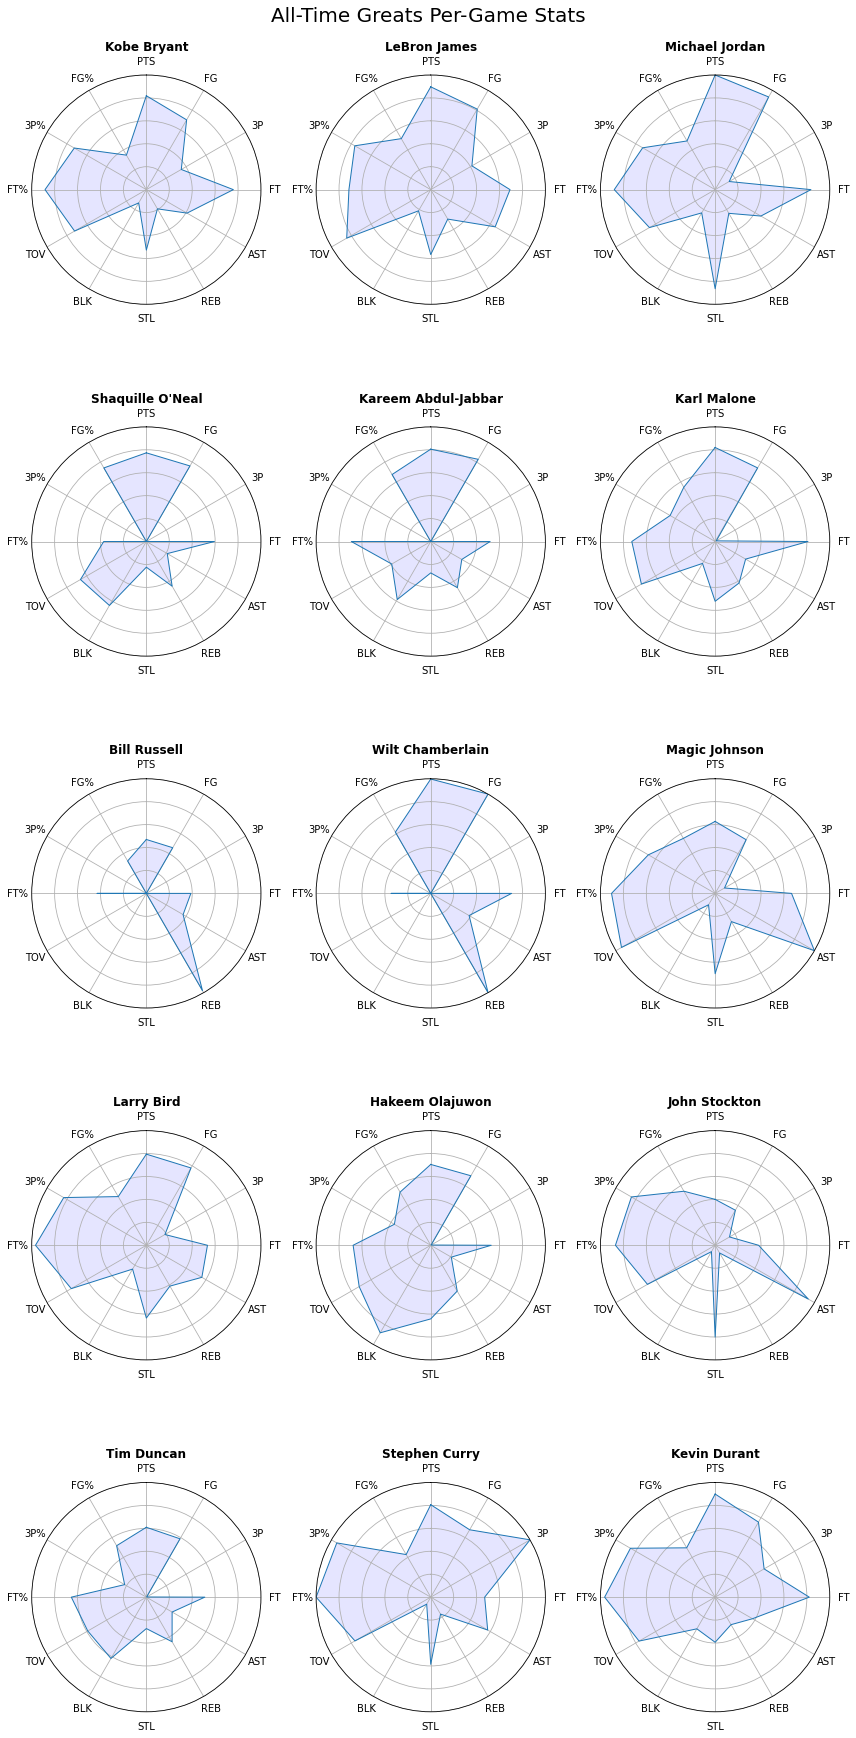

In [80]:
fig = plt.figure(figsize=(12, 25))
for i, player in enumerate(all_time_greats):
    ax = plt.subplot(5, 3, i + 1, polar=True)
    scaled_player_data = scaled_pergame_data.loc[scaled_pergame_data.Player == str(player)].copy()
    radar_factory(columns_names_shown,
                  list(scaled_player_data[pergame_data_columns].values[0]), 
                  player, axes=ax, fontsize=10)
fig.suptitle('All-Time Greats Per-Game Stats', fontsize=20, fontweight='light')
fig.tight_layout() #removes empty space under title
plt.show()

#### Conclusions
This visualization is much better to see how each all-time great affected the games he played in. Of course due to some missing stats e.g. during the years of Bill Russell the turnovers, steals and blocks were not being recorded, we can not have the whole picture. Also, players like Lebron, Durant, Kobe and Jordan have very similar plots since they played similar roles in their teams but have achieved different things in their careers. In conclusion, I believe it is impossible to only pick one player as the greatest of all time due to the plethora of factors and stats categories that exist, the difference of basketball eras and the impossibility of seeing the all-time greats compete against each other. However, it seems like Michael Jordan and Lebron James are head-to-head the greatest basketball players of all time.